In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bs4 as bs
import xml.etree.ElementTree as ET
import json
import mpld3
mpld3.enable_notebook()
% matplotlib inline

In [3]:
import os
os.chdir("/Users/Simon/Desktop/thesis_analyses")

# xml2json

install:

    `pip install https://github.com/hay/xml2json/zipball/master`

convert:

    `xml2json $f -o $f.json --strip_text`

# utils

In [4]:
def extract(suffix, data):
    """
    Return dict with string values from data.
    
    Arguments:
        suffix (str): string to be added to keys.
        data (dict): dictionary containing data.
        
    Returns:
        dict: string only dictionary.
    """
    return {
        suffix + k.lower().replace("@", ""): v.rstrip().lstrip()
        for k, v in data.items() if type(v) is str
        }

def write_master_dataframe(paths):
    """
    Creates a dataframe given json files.
    
    **Flowchart**
    #. 
    #.
    """
    data = []
    for p in paths:

        print("reading: " + p)
        with open(p, "r") as f:
            tree = json.load(f)
#             copy = tree.copy()

        row = dict()
        s = tree["subject"]
        row.update(extract("subject__", s))

        i = 0
        for a in s["attempt"]:
            row.update(extract("attempt__", a))

            j = 0
            for  f in a["frame"]:
                row.update(extract("frame__", f))

                for key in ['spherical', 'angle', 'cartesian']:
                    row.update(extract("frame__", f[key]))

                data.append(row.copy())
                if f.get("@triggered") == "1":
#                     copy["subject"]["attempt"][i]["frame"] = copy["subject"]["attempt"][i]["frame"][:j+1]
                    break
                j += 1
            i += 1
        
#         with open("data/" + s["@name"].strip() + "__training.json", "w") as f:
#             json.dump(copy, f)

    df = pd.DataFrame(data)
    df.columns = sorted(df.columns)

    for col in df.columns:
        try:
            df[col] = pd.to_numeric(df[col])
        except ValueError:
            pass
    
    df.to_csv("master_df.tsv", sep="\t", index=False)

def load_master_dataframe():
    df = pd.read_table("master_df.tsv", dtype="unicode")
    df.columns = sorted(df.columns)

    for col in df.columns:
        try:
            df[col] = pd.to_numeric(df[col])
        except ValueError:
            pass
    
    return df

In [5]:
paths = [
    "data/A.json",
    "data/B.json",
    "data/C.json",
    "data/D.json",
    "data/E.json",
    "data/F.json",
    "data/G.json",
    "data/H.json",
    "data/I.json",
    "data/J.json",
    "data/K.json",
    "data/L.json",
    "data/M.json",
    "data/N.json",
    "data/O.json",
    "data/P.json",
    ]

# paths = [
#     "data/A__training.json",
#     "data/B__training.json",
#     "data/C__training.json",
#     "data/D__training.json",
#     "data/E__training.json",
#     "data/F__training.json",
#     "data/G__training.json",
#     "data/H__training.json",
#     "data/I__training.json",
#     "data/J__training.json",
#     "data/K__training.json",
#     "data/M__training.json",
#     "data/N__training.json",
#     "data/O__training.json",
#     "data/P__training.json",
#    ]

write_master_dataframe(paths)
df = load_master_dataframe()

reading: data/A.json
reading: data/B.json
reading: data/C.json
reading: data/D.json
reading: data/E.json
reading: data/F.json
reading: data/G.json
reading: data/H.json
reading: data/I.json
reading: data/J.json
reading: data/K.json
reading: data/L.json
reading: data/M.json
reading: data/N.json
reading: data/O.json
reading: data/P.json


In [6]:
#Adding Gender

gender = {s: "male" for s in "DGHJKMNO"}
gender.update({s: "female" for s in "ABCEFIPL"})
df["subject__gender"] = df["subject__name"].map(gender)
df["frame__y"] = df["frame__y"].abs()
df["frame__θ"] = df["frame__θ"].abs()
df["frame__φ"] = df["frame__φ"].abs()

#Adding Experience

experience = {s: "Experienced" for s in "ADEFGHKOP"}
experience.update({s: "NotExperienced" for s in "BCIJLMN"})
df["subject__experience"] = df["subject__name"].map(experience)

# Data Analysis

In [8]:
filters = (df["frame__triggered"] == 1)
cols = ["frame__rotationspeed", "frame__time", "frame__totarget","frame__φ","frame__θ"]

traning_groupby = df[filters].groupby("attempt__training")
traning_groupby[cols].describe(percentiles=[.25, .5, .75, 0.95])

frame__rotationspeed  frame__time  frame__totarget  \
attempt__training                                                             
0                 count            314.000000   314.000000       314.000000   
                  mean               8.329793     4.414331        19.592338   
                  std               34.150970     4.319196        24.490019   
                  min                0.000000     0.980000         1.127959   
                  25%                1.071824     2.342500         7.874924   
                  50%                2.791575     3.475000        14.450130   
                  75%                6.110209     4.710000        22.250520   
                  95%               25.478628     9.042000        43.730739   
                  max              563.366200    39.450000       172.752100   
1                 count            145.000000   145.000000       145.000000   
                  mean               4.490122     5.116207        18.399907   
                  std                6.643022     3.851364        15.175626   
                  min                0.000000     1.100000         0.549296   
                  25%                1.249356     2.700000         8.991628   
                  50%                2.499361     3.990000        14.627620   
                  75%                4.802607     6.320000        23.676240   
                  95%               15.846430    11.124000        40.984842   
                  max               54.955250    25.110000       130.979300   

                           frame__φ    frame__θ  
attempt__training                                
0                 count  314.000000  314.000000  
                  mean    13.293885   10.371019  
                  std     11.493233   25.390380  
                  min      0.060000    0.040000  
                  25%      4.580000    2.190000  
                  50%      9.995000    4.820000  
                  75%     19.027500    9.140000  
                  95%     37.289500   18.149000  
                  max     63.660000  172.800000  
1                 count  145.000000  145.000000  
                  mean    15.942069    6.756966  
                  std     12.798458   14.465965  
                  min      0.460000    0.070000  
                  25%      6.190000    2.020000  
                  50%     12.130000    4.630000  
                  75%     21.520000    8.870000  
                  95%     40.348000   13.588000  
                  max     56.360000  171.350000

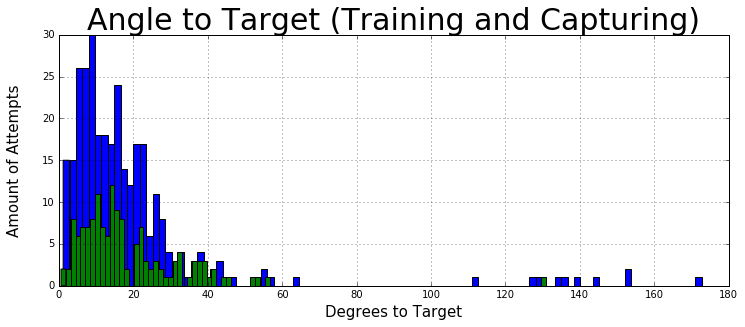

In [9]:
#Unfiltered data : Degegrees to Target vs Amount of people


plt.figure(figsize=(12, 4.5))
traning_groupby.frame__totarget.hist(bins=100)

plt.title('Angle to Target (Training and Capturing)', size = 30)
plt.xlabel('Degrees to Target', size = 15)
plt.ylabel('Amount of Attempts', size = 15, labelpad=20)
plt.xlim(xmax=180)
plt.savefig("Table1.png")


# I determiend that there should be a filter in azimuth after 80 Degrees

In [10]:
filters = (df["frame__triggered"] == 1)
filters &= (df["frame__totarget"] <= 80)
df["frame__y"] = df["frame__y"].abs()
df["frame__θ"] = df["frame__θ"].abs()
df["frame__φ"] = df["frame__φ"].abs()
cols = ["frame__rotationspeed", "frame__time", "frame__totarget","frame__φ","frame__θ"]

traning_groupby = df[filters].groupby("attempt__training")
traning_groupby[cols].describe(percentiles=[.25, .5, .75, 0.95])

frame__rotationspeed  frame__time  frame__totarget  \
attempt__training                                                             
0                 count            304.000000   304.000000       304.000000   
                  mean               8.091425     3.944704        15.627384   
                  std               34.312890     2.866603        10.768076   
                  min                0.000000     0.980000         1.127959   
                  25%                0.970520     2.327500         7.762708   
                  50%                2.709044     3.410000        13.749655   
                  75%                6.063677     4.682500        21.366635   
                  95%               25.325852     7.485500        37.232312   
                  max              563.366200    24.190000        64.027290   
1                 count            144.000000   144.000000       144.000000   
                  mean               4.521304     4.977361        17.618105   
                  std                6.655552     3.481646        11.944221   
                  min                0.000000     1.100000         0.549296   
                  25%                1.256994     2.700000         8.978776   
                  50%                2.502200     3.985000        14.589350   
                  75%                4.835115     6.320000        23.037930   
                  95%               15.911960    10.933500        40.272209   
                  max               54.955250    21.430000        56.399650   

                           frame__φ    frame__θ  
attempt__training                                
0                 count  304.000000  304.000000  
                  mean    13.274868    5.890066  
                  std     11.349783    4.768598  
                  min      0.060000    0.040000  
                  25%      4.580000    2.170000  
                  50%     10.270000    4.670000  
                  75%     19.087500    8.590000  
                  95%     36.869500   14.981500  
                  max     63.660000   31.190000  
1                 count  144.000000  144.000000  
                  mean    15.716319    5.613958  
                  std     12.550088    4.468254  
                  min      0.460000    0.070000  
                  25%      6.130000    2.020000  
                  50%     11.990000    4.580000  
                  75%     21.407500    8.847500  
                  95%     39.973500   13.319000  
                  max     56.360000   19.900000

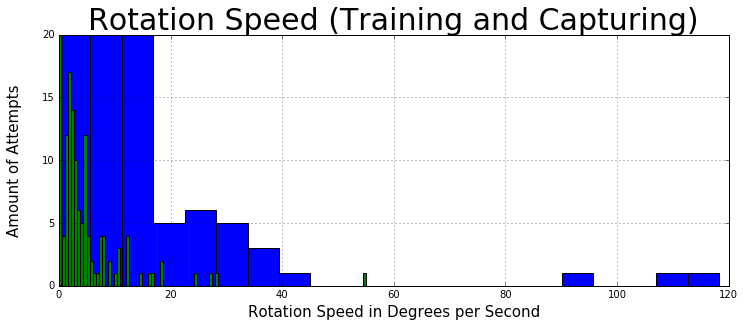

In [11]:
plt.figure(figsize=(12, 4.5))
traning_groupby.frame__rotationspeed.hist(bins=100)
plt.ylim(ymax=20)

plt.title('Rotation Speed (Training and Capturing)', size = 30)
plt.xlabel('Rotation Speed in Degrees per Second', size = 15)
plt.ylabel('Amount of Attempts', size = 15, labelpad=20)
plt.savefig("Table2.png")
plt.xlim(xmax= 120)
plt.savefig("Table4.png")


In [12]:
filters = (df["frame__triggered"] == 1)
filters &= (df["frame__totarget"] <= 80)
filters &= (df["frame__rotationspeed"] < 60)
df["frame__y"] = df["frame__y"].abs()
df["frame__θ"] = df["frame__θ"].abs()
df["frame__φ"] = df["frame__φ"].abs()
cols = ["frame__rotationspeed", "frame__time", "frame__totarget","frame__φ","frame__θ"]

traning_groupby = df[filters].groupby("attempt__training")
traning_groupby[cols].describe(percentiles=[0.95])

frame__rotationspeed  frame__time  frame__totarget  \
attempt__training                                                             
0                 count            300.000000   300.000000       300.000000   
                  mean               5.252333     3.968467        15.576368   
                  std                7.427307     2.878029        10.758938   
                  min                0.000000     0.980000         1.127959   
                  50%                2.653059     3.450000        13.584810   
                  95%               21.303463     7.493500        37.430082   
                  max               44.700230    24.190000        64.027290   
1                 count            144.000000   144.000000       144.000000   
                  mean               4.521304     4.977361        17.618105   
                  std                6.655552     3.481646        11.944221   
                  min                0.000000     1.100000         0.549296   
                  50%                2.502200     3.985000        14.589350   
                  95%               15.911960    10.933500        40.272209   
                  max               54.955250    21.430000        56.399650   

                           frame__φ    frame__θ  
attempt__training                                
0                 count  300.000000  300.000000  
                  mean    13.267833    5.797500  
                  std     11.354682    4.691824  
                  min      0.060000    0.040000  
                  50%     10.270000    4.670000  
                  95%     37.118500   14.574000  
                  max     63.660000   31.190000  
1                 count  144.000000  144.000000  
                  mean    15.716319    5.613958  
                  std     12.550088    4.468254  
                  min      0.460000    0.070000  
                  50%     11.990000    4.580000  
                  95%     39.973500   13.319000  
                  max     56.360000   19.900000

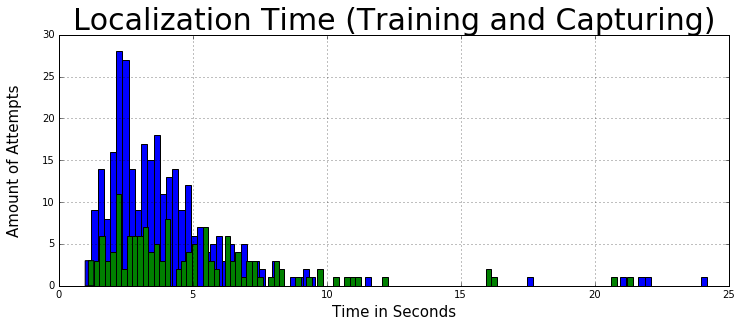

In [13]:
plt.figure(figsize=(12, 4.5))
traning_groupby.frame__time.hist(bins=100)

plt.title('Localization Time (Training and Capturing)', size = 30)
plt.xlabel('Time in Seconds', size = 15)
plt.ylabel('Amount of Attempts', size = 15, labelpad=20)

plt.savefig("Table3.png")

In [14]:
filters = (df["frame__triggered"] == 1)
filters &= (df["frame__totarget"] <= 80)
filters &= (df["frame__time"] <= 15)
filters &= (df["frame__rotationspeed"] < 150)
cols = ["frame__rotationspeed", "frame__time", "frame__totarget","frame__φ","frame__θ"]

traning_groupby = df[filters].groupby("attempt__training")
traning_groupby[cols].describe(percentiles=[0.9])

frame__rotationspeed  frame__time  frame__totarget  \
attempt__training                                                             
0                 count            298.000000   298.000000       298.000000   
                  mean               6.357878     3.659765        15.513593   
                  std               12.608733     1.771231        10.708375   
                  min                0.000000     0.980000         1.127959   
                  50%                2.761196     3.360000        13.584810   
                  90%               15.247631     6.072000        28.016451   
                  max              114.093200    11.560000        64.027290   
1                 count            139.000000   139.000000       139.000000   
                  mean               4.606505     4.506547        17.521259   
                  std                6.752487     2.431073        11.832827   
                  min                0.000000     1.100000         0.549296   
                  50%                2.505039     3.960000        14.551080   
                  90%               10.848740     7.874000        36.036682   
                  max               54.955250    12.150000        56.399650   

                           frame__φ    frame__θ  
attempt__training                                
0                 count  298.000000  298.000000  
                  mean    13.207282    5.772953  
                  std     11.358707    4.550506  
                  min      0.060000    0.040000  
                  50%      9.995000    4.670000  
                  90%     26.873000   12.650000  
                  max     63.660000   20.870000  
1                 count  139.000000  139.000000  
                  mean    15.670288    5.543165  
                  std     12.410625    4.423031  
                  min      0.460000    0.070000  
                  50%     12.130000    4.530000  
                  90%     34.912000   11.512000  
                  max     56.360000   19.900000

In [15]:
# Data filtering

filters = (df["frame__triggered"] == 1)
filters &= (df["frame__totarget"] > 80)


attemptsToDelete= {}

for index, row in df[filters].iterrows():
    if row["subject__name"] not in attemptsToDelete:
        attemptsToDelete[row["subject__name"]] = [row["attempt__count"]]
    else:
        attemptsToDelete[row["subject__name"]].append(row["attempt__count"])


for attempt in attemptsToDelete.items():
    df = df[(df["subject__name"] != attempt[0]) | (df["attempt__count"].isin(attempt[1])== False)]
    
filters = (df["frame__triggered"] == 1)
filters &= (df["frame__time"] > 15)

attemptsToDelete= {}

for index, row in df[filters].iterrows():
    if row["subject__name"] not in attemptsToDelete:
        attemptsToDelete[row["subject__name"]] = [row["attempt__count"]]
    else:
        attemptsToDelete[row["subject__name"]].append(row["attempt__count"])


for attempt in attemptsToDelete.items():
    df = df[(df["subject__name"] != attempt[0]) | (df["attempt__count"].isin(attempt[1])== False)]
    
filters = (df["frame__triggered"] == 1)
filters &= (df["frame__rotationspeed"] > 80)

attemptsToDelete= {}

for index, row in df[filters].iterrows():
    if row["subject__name"] not in attemptsToDelete:
        attemptsToDelete[row["subject__name"]] = [row["attempt__count"]]
    else:
        attemptsToDelete[row["subject__name"]].append(row["attempt__count"])


for attempt in attemptsToDelete.items():
    df = df[(df["subject__name"] != attempt[0]) | (df["attempt__count"].isin(attempt[1])== False)]


In [16]:
# Data filtering


dfnew = df
filters = (dfnew["frame__triggered"] == 1)
filters &= (dfnew["frame__time"] < 10)
attemptsToDelete= {}

for index, row in dfnew[filters].iterrows():
    if row["subject__name"] not in attemptsToDelete:
        attemptsToDelete[row["subject__name"]] = [row["attempt__count"]]
    else:
        attemptsToDelete[row["subject__name"]].append(row["attempt__count"])


for attempt in attemptsToDelete.items():
    dfnew = dfnew[(dfnew["subject__name"] != attempt[0]) | (dfnew["attempt__count"].isin(attempt[1])== False)]

In [17]:
filters = (dfnew["frame__triggered"] == 1)

cols = ["frame__rotationspeed", "frame__time", "frame__totarget","frame__φ","frame__θ"]
traning_groupby = dfnew[filters].groupby("attempt__training")
traning_groupby[cols].describe(percentiles=[0.95])

frame__rotationspeed  frame__time  frame__totarget  \
attempt__training                                                             
0                 count              1.000000     1.000000         1.000000   
                  mean               3.539081    11.560000        17.943920   
                  std                     NaN          NaN              NaN   
                  min                3.539081    11.560000        17.943920   
                  50%                3.539081    11.560000        17.943920   
                  95%                3.539081    11.560000        17.943920   
                  max                3.539081    11.560000        17.943920   
1                 count              5.000000     5.000000         5.000000   
                  mean               2.004527    11.066000        18.675206   
                  std                1.654588     0.676853         9.175974   
                  min                0.991547    10.370000         5.414501   
                  50%                1.223626    10.980000        22.350590   
                  95%                4.277780    11.952000        27.757384   
                  max                4.932639    12.150000        28.990440   

                          frame__φ   frame__θ  
attempt__training                              
0                 count   1.000000   1.000000  
                  mean   17.840000   1.940000  
                  std          NaN        NaN  
                  min    17.840000   1.940000  
                  50%    17.840000   1.940000  
                  95%    17.840000   1.940000  
                  max    17.840000   1.940000  
1                 count   5.000000   5.000000  
                  mean   15.830000   6.954000  
                  std    11.010972   5.211361  
                  min     3.560000   1.430000  
                  50%    19.240000   4.740000  
                  95%    27.494000  12.992000  
                  max    28.780000  13.340000

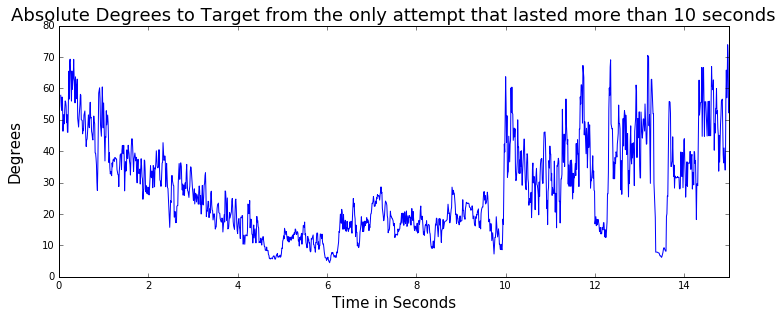

In [18]:

fig, ax = plt.subplots()

fil = (dfnew["frame__time"] <= 15)
fil &= (dfnew["attempt__training"] == 0)

dfnew[fil].groupby("frame__time").mean().rolling(5).mean().plot(
    y="frame__totarget",
    ax=ax,
    legend=False,
    figsize=(12, 4.5))

plt.title('Absolute Degrees to Target from the only attempt that lasted more than 10 seconds', size = 18)
plt.xlabel('Time in Seconds', size = 15)
plt.ylabel('Degrees', size = 15, labelpad=20)

plt.savefig("Table6.png")

In [19]:
filters = (df["frame__triggered"] == 1)
filters &= (df["attempt__training"] == 0)
cols = ["frame__rotationspeed", "frame__time", "frame__totarget", "frame__φ","frame__θ"]
traning_groupby = df[filters].groupby("subject__name")
traning_groupby[cols].mean()

,frame__rotationspeed,frame__time,frame__totarget,frame__φ,frame__θ
subject__name,,,,,
A,1.113271,3.663889,10.104241,7.141667,5.570556
B,13.965758,2.843000,10.392340,8.855500,4.198500
C,3.713028,5.956667,12.114761,6.971667,8.030000
D,11.987800,3.040667,24.926072,23.738667,4.958000
E,5.363747,4.661000,15.804116,13.709500,5.706000
F,3.253773,5.330500,13.452175,13.092000,2.015000
G,3.480234,3.585263,15.456137,13.757895,5.130000
H,9.999855,2.077368,18.183213,16.226316,7.046316
I,7.351529,1.631000,11.093692,10.406000,2.852000


In [20]:
filters = (df["frame__triggered"] == 1)
cols = ["frame__rotationspeed", "frame__time", "frame__totarget","frame__φ","frame__θ"]
traning_groupby = df[filters].groupby("attempt__training")
traning_groupby[cols].describe(percentiles=[0.95])
#traning_groupby[cols].median()

frame__rotationspeed  frame__time  frame__totarget  \
attempt__training                                                             
0                 count            295.000000   295.000000       295.000000   
                  mean               5.335324     3.674610        15.421551   
                  std                7.461890     1.773726        10.699784   
                  min                0.000000     0.980000         1.127959   
                  50%                2.713283     3.400000        13.447180   
                  95%               21.935628     7.083000        37.523839   
                  max               44.700230    11.560000        64.027290   
1                 count            139.000000   139.000000       139.000000   
                  mean               4.606505     4.506547        17.521259   
                  std                6.752487     2.431073        11.832827   
                  min                0.000000     1.100000         0.549296   
                  50%                2.505039     3.960000        14.551080   
                  95%               16.197143     9.350000        40.549939   
                  max               54.955250    12.150000        56.399650   

                           frame__φ    frame__θ  
attempt__training                                
0                 count  295.000000  295.000000  
                  mean    13.155864    5.671559  
                  std     11.368808    4.456005  
                  min      0.060000    0.040000  
                  50%      9.940000    4.650000  
                  95%     37.261000   14.416000  
                  max     63.660000   20.870000  
1                 count  139.000000  139.000000  
                  mean    15.670288    5.543165  
                  std     12.410625    4.423031  
                  min      0.460000    0.070000  
                  50%     12.130000    4.530000  
                  95%     40.166000   13.214000  
                  max     56.360000   19.900000

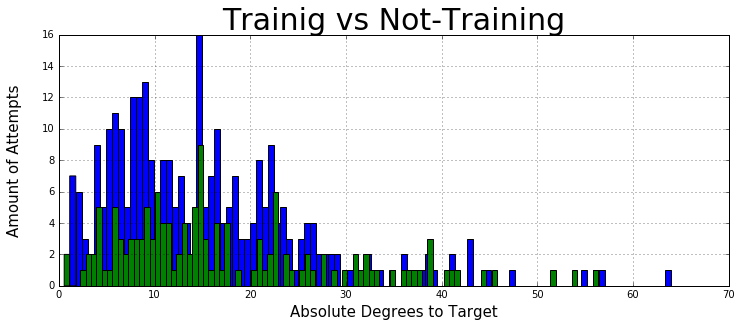

In [21]:
plt.figure(figsize=(12, 4.5))
traning_groupby.frame__totarget.hist(bins=100)

plt.title('Trainig vs Not-Training', size = 30)
plt.xlabel('Absolute Degrees to Target', size = 15)
plt.ylabel('Amount of Attempts', size = 15, labelpad=20)


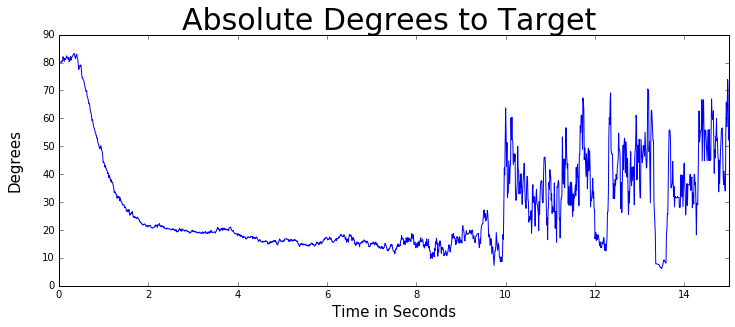

In [22]:

fig, ax = plt.subplots()

fil = (df["frame__time"] <= 15)
fil &= (df["attempt__training"] == 0)

df[fil].groupby("frame__time").mean().rolling(5).mean().plot(
    y="frame__totarget",
    ax=ax,
    legend=False,
    figsize=(12, 4.5))

plt.title('Absolute Degrees to Target ', size = 30)
plt.xlabel('Time in Seconds', size = 15)
plt.ylabel('Degrees', size = 15, labelpad=20)

plt.savefig("Table5.png")

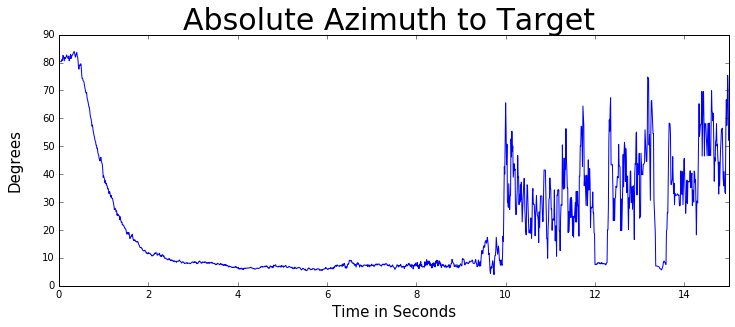

In [23]:

fig, ax = plt.subplots()

fil = (df["frame__time"] <= 15)
fil &= (df["attempt__training"] == 0)

df[fil].groupby("frame__time").mean().rolling(5).mean().plot(
    y="frame__θ",
    ax=ax,
    legend=False,
    figsize=(12, 4.5))

plt.title('Absolute Azimuth to Target ', size = 30)
plt.xlabel('Time in Seconds', size = 15)
plt.ylabel('Degrees', size = 15, labelpad=20)


(0, 90.0)

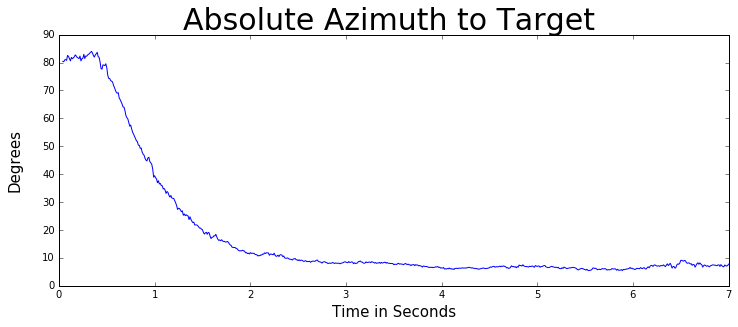

In [24]:
fig, ax = plt.subplots()

# Because 90% of the attempts are under 7 seconds, I set up that as my time
# to analyse timed data
fil = (df["frame__time"] <= 7)
fil &= (df["attempt__training"] == 0)
df[fil].groupby("frame__time").mean().rolling(5).mean().plot(
    y="frame__θ",
    ax=ax,
    legend=False,
figsize=(12, 4.5))

plt.title('Absolute Azimuth to Target ', size = 30)
plt.xlabel('Time in Seconds', size = 15)
plt.ylabel('Degrees', size = 15, labelpad=20)
ax.set_ylim(ymin=0)

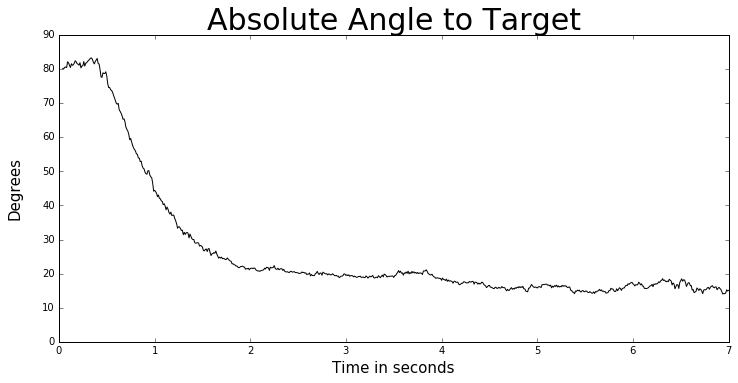

In [25]:
fil = (df["frame__time"] <=7)
fil &= (df["attempt__training"] == 0)


mean = df[fil].groupby("frame__time")["frame__totarget"].mean().rolling(5).mean()
std = df[fil].groupby("frame__time")["frame__totarget"].std()
X = 2

plt.figure(figsize=(12, 5.5))
plt.plot(mean.index, mean, 'k')
plt.ylim(ymin=0, ymax =90 )
plt.title('Absolute Angle to Target', size = 30)
plt.xlabel('Time in seconds', size = 15)
plt.ylabel('Degrees', size = 15, labelpad=20)
#plt.fill_between(std.index, mean - X * std, mean + X * std, color='b', alpha=0.2)

plt.savefig("Table7.png")

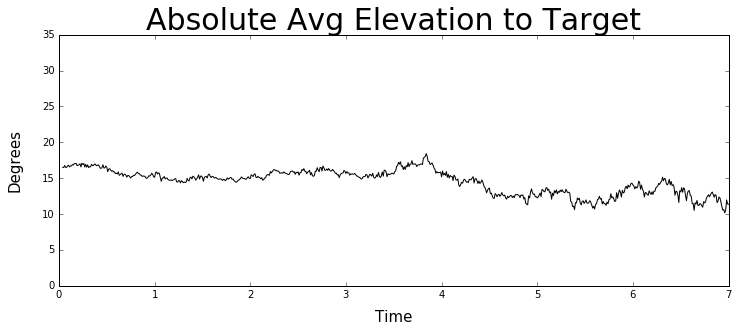

In [26]:
fil = (df["frame__time"] <=7)
fil &= (df["attempt__training"] == 0)
#fil &= (df["frame__totarget"] <= 80)
#fil &= (df["frame__rotationspeed"] < 250)

mean = df[fil].groupby("frame__time")["frame__φ"].mean().rolling(5).mean()
std = df[fil].groupby("frame__time")["frame__φ"].std().rolling(5).mean()
X = 1

plt.figure(figsize=(12, 4.5))
plt.plot(mean.index, mean, 'k')
#plt.fill_between(std.index, mean - X * std, mean + X * std, color='b', alpha=0.2)
plt.title('Absolute Avg Elevation to Target', size = 30)
plt.xlabel('Time', size = 15,labelpad=10)
plt.ylabel('Degrees', size = 15, labelpad=20)
plt.ylim(ymin=0)
plt.ylim(ymax=35)
plt.savefig("Table9.png")

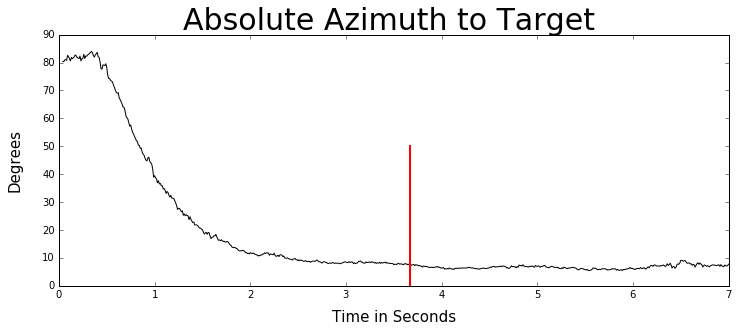

In [27]:
fil = (df["frame__time"] <=7)
fil &= (df["attempt__training"] == 0)
#fil &= (df["frame__totarget"] <= 80)
#fil &= (df["frame__rotationspeed"] < 250)

mean = df[fil].groupby("frame__time")["frame__θ"].mean() .rolling(5).mean()
std = df[fil].groupby("frame__time")["frame__θ"].std() .rolling(5).mean()
X = 1

plt.figure(figsize=(12, 4.5))
#plt.grid()
plt.plot(mean.index, mean, 'k')
plt.ylim(ymin= 0 )
plt.ylim(ymax=90)

plt.title('Absolute Azimuth to Target ', size = 30)
plt.xlabel('Time in Seconds', size = 15, labelpad=10)
plt.ylabel('Degrees', size = 15, labelpad=20)
#plt.fill_between(std.index, mean - X * std, mean + X * std, color='b', alpha=0.2)
plt.plot([3.674610, 3.674610],[0,50],'k-', lw=2, color='r')
plt.savefig("Table8.png")

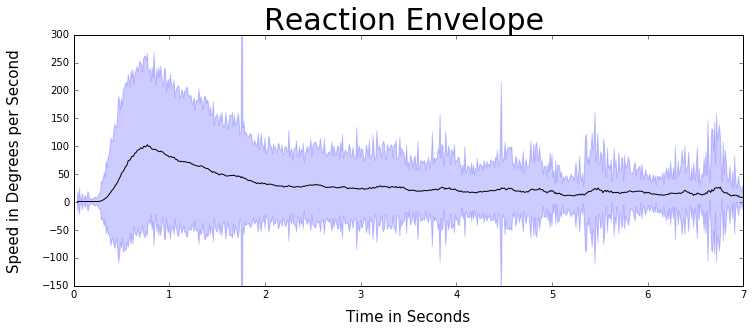

In [28]:
fil = (df["frame__time"] <= 7)
fil &= (df["attempt__training"] == 0)


mean = df[fil].groupby("frame__time")["frame__rotationspeed"].mean().rolling(5).mean()
std = df[fil].groupby("frame__time")["frame__rotationspeed"].std()
X = 2

plt.figure(figsize=(12, 4.5))
plt.plot(mean.index, mean, 'k')
#plt.plot([3.950957, 3.950957],[0,50],'k-', lw=2, color='r')
plt.title('Reaction Envelope ', size = 30)
plt.xlabel('Time in Seconds', size = 15, labelpad=10)
plt.ylabel('Speed in Degrees per Second', size = 15, labelpad=20)

plt.ylim(ymax=300)
plt.ylim(ymin=-150)
#plt.fill_between(std.index, mean - X * std, mean + X * std, color='b', alpha=0.2)
plt.savefig("Table9.png")

39
84
64
49
25
15
8
3
3
{2: 17.513963179487174, 3: 14.51766023809524, 4: 16.916868234375, 5: 14.061300061224493, 6: 15.596798439999997, 7: 17.476641533333332, 8: 11.524971875000002, 9: 9.552940333333334, 10: 13.396744666666669}


TypeError: 0 is not JSON serializable

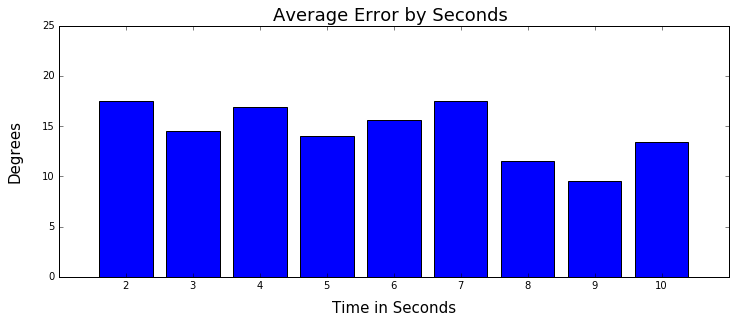

In [44]:
#fig, ax = plt.subplots()

fil = (df["frame__time"] <=10)
fil &= (df["attempt__training"] == 0)
fil &= (df["frame__totarget"] <= 80)
fil &= (df["frame__rotationspeed"] < 250)
fil &=(df["frame__triggered"] == 1)

g = {}

for index, row in df[fil].iterrows(): 
    i = 2
    
    while (i <= 10):
        if row["frame__time"] < i and row["frame__time"] > (i-1):
            if i not in g:
                g[i] = [row["frame__totarget"]]
                
            else:
        
                g[i].append(row["frame__totarget"])  
            i = i + 1    
        else:
            i = i + 1


i = 2            
for row in g:
    print(len(g[i]))
    g[i] = sum(g[i])/len(g[i])
    i = i+1

print(g)



plt.figure(figsize=(12, 4.5))
plt.bar(range(len(g)), g.values(), align='center')
plt.xticks(range(len(g)), g.keys())
plt.title('Average Error by Seconds ', size = 18)
plt.xlabel('Time in Seconds', size = 15, labelpad=10)
plt.ylabel('Degrees', size = 15, labelpad=20)

plt.ylim(ymax=25)
plt.savefig("Table12.png")
    

In [30]:
## GENDER ANALYSIS

In [31]:
filters = (df["frame__triggered"] == 1)
filters &= (df["attempt__training"] == 0)
cols = ["frame__rotationspeed", "frame__time", "frame__totarget","frame__φ","frame__θ"]


gender_groupby = df[filters].groupby("subject__gender")
gender_groupby[cols].median()
#gender_groupby[cols].describe(percentiles=[ 0.9])

,frame__rotationspeed,frame__time,frame__totarget,frame__φ,frame__θ
subject__gender,,,,,
female,2.172193,3.64,10.003028,7.55,3.655
male,3.205020,2.72,16.373800,13.79,5.660


In [32]:
filters = (df["frame__triggered"] == 1)
filters &= (df["attempt__training"] == 0)
cols = ["frame__rotationspeed", "frame__time", "frame__totarget","frame__φ","frame__θ"]


gender_groupby = df[filters].groupby("subject__experience")
gender_groupby[cols].describe()
gender_groupby[cols].describe(percentiles=[ 0.95])

frame__rotationspeed  frame__time  frame__totarget  \
subject__experience                                                             
Experienced         count            167.000000   167.000000       167.000000   
                    mean               5.057422     3.609162        15.579946   
                    std                6.838091     1.720425        11.299207   
                    min                0.000000     1.150000         1.127959   
                    50%                2.781186     3.280000        13.358870   
                    95%               21.566213     6.940000        37.235647   
                    max               35.156340    11.560000        64.027290   
NotExperienced      count            128.000000   128.000000       128.000000   
                    mean               5.697899     3.760000        15.214896   
                    std                8.218503     1.844269         9.903264   
                    min                0.000000     0.980000         1.214826   
                    50%                2.582743     3.520000        13.749655   
                    95%               21.093758     7.415500        36.870076   
                    max               44.700230     9.330000        54.777340   

                             frame__φ    frame__θ  
subject__experience                                
Experienced         count  167.000000  167.000000  
                    mean    14.198383    4.363653  
                    std     11.811296    3.464998  
                    min      0.130000    0.060000  
                    50%     11.710000    3.310000  
                    95%     37.048000   11.389000  
                    max     63.660000   17.020000  
NotExperienced      count  128.000000  128.000000  
                    mean    11.795703    7.377969  
                    std     10.656785    5.008842  
                    min      0.060000    0.040000  
                    50%      8.645000    6.650000  
                    95%     36.358500   16.695500  
                    max     54.370000   20.870000

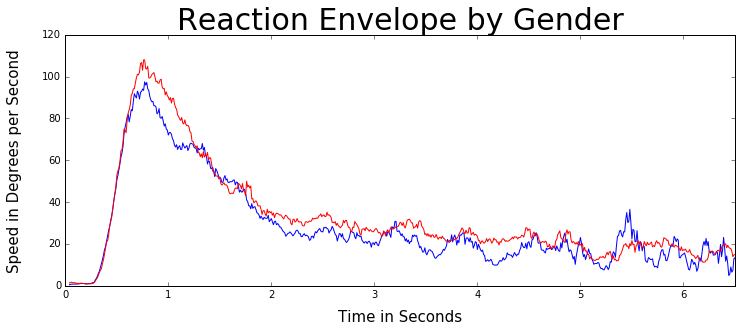

In [49]:
#Gender Reaction Envelope

fil = (df["frame__time"] <=15)
fil &= (df["attempt__training"] == 0)
fil &= (df["subject__gender"] == "male")

fil2 = (df["frame__time"] <=15)
fil2 &= (df["attempt__training"] == 0)
fil2 &= (df["subject__gender"] == "female")

mean = df[fil].groupby("frame__time")["frame__rotationspeed"].mean().rolling(5).mean()
mean2 = df[fil2].groupby("frame__time")["frame__rotationspeed"].mean().rolling(5).mean()


plt.figure(figsize=(12, 4.5))
plt.plot(mean.index, mean, 'k', color ="b")
plt.plot(mean2.index, mean2, 'k', color ="r")
plt.xlim(xmax=6.5)
plt.title('Reaction Envelope by Gender', size = 30)
plt.xlabel('Time in Seconds', size = 15, labelpad=10)
plt.ylabel('Speed in Degrees per Second', size = 15, labelpad=20)


plt.savefig("Table11.png")

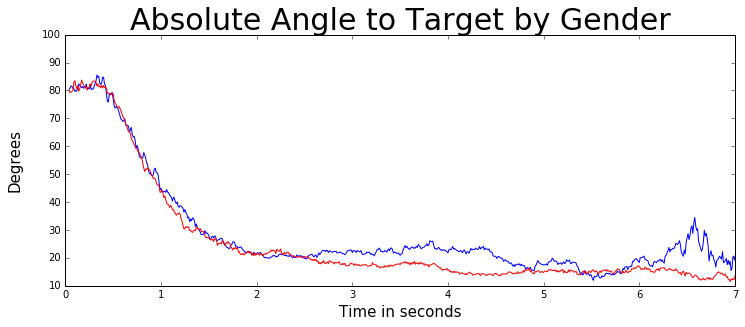

In [47]:
fil = (df["frame__time"] <=7)
fil &= (df["attempt__training"] == 0)
fil &= (df["subject__gender"] == "male")

fil2 = (df["frame__time"] <=7)
fil2 &= (df["attempt__training"] == 0)
fil2 &= (df["subject__gender"] == "female")

mean = df[fil].groupby("frame__time")["frame__totarget"].mean().rolling(5).mean()
mean2 = df[fil2].groupby("frame__time")["frame__totarget"].mean().rolling(5).mean()


plt.figure(figsize=(12, 4.5))
plt.plot(mean.index, mean, 'k', color ="b")
plt.plot(mean2.index, mean2, 'k', color ="r")
plt.ylim(ymax=100)
plt.title('Absolute Angle to Target by Gender', size = 30)
plt.xlabel('Time in seconds', size = 15)
plt.ylabel('Degrees', size = 15, labelpad=20)

plt.savefig("Table13.png")

In [35]:
from collections import Counter

Subjects = {}

for index, row in df.iterrows():
    if row["attempt__training"] == 1:
            Subjects[row["subject__name"]] = row["attempt__count"]

values = list(Subjects.values())

counts = Counter(values)
# kd = pd.DataFrame.from_dict(counts, orient='index')
# kd.plot(kind='bar')
Subjects

{'A': 7,
 'B': 15,
 'C': 8,
 'D': 11,
 'E': 7,
 'F': 11,
 'G': 7,
 'H': 8,
 'I': 7,
 'J': 7,
 'M': 17,
 'N': 26,
 'O': 7,
 'P': 7}

In [36]:
df[df["attempt__training"]  == 1] \
    [["attempt__count", "subject__name"]] \
    .drop_duplicates() \
    ["subject__name"] \
    .value_counts()
    
    #Gender analysis
    #Azimuth and vertical vs Error
    # Add yes and No 

N    26
M    14
B    13
F    11
D    10
C     8
H     8
J     7
O     7
P     7
A     7
G     7
I     7
E     7
Name: subject__name, dtype: int64